### Vehicle Detection Project
The goals / steps of this Python nodebook are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier

* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.

* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.

* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.

* Estimate a bounding box for vehicles detected.



In [40]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
from moviepy.editor import VideoFileClip
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
import random
from scipy.ndimage.measurements import label
from skimage.feature import hog


# the following give 1.0 Accuracy
cspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
#cspace = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
#cell_per_block = 3
#cell_per_block = 4
cell_per_block = 5

hog_channel = "ALL"
histogram_bins=32

xy_window_size = (64, 64)
xy_overlap_size = (0.5, 0.5)

y_start_stop = [400, 720]


In [149]:
def normalize_feature(X):
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    
    return scaled_X,X_scaler


def get_hog_features(img, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=True,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=True,
                       visualise=vis, feature_vector=feature_vec)
    return features

def get_color_histogram(img, nbins=32, bins_range=(0, 256)):
    channel1_histogram = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_histogram = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_histogram = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    histogram_features = np.concatenate((channel1_histogram[0], channel2_histogram[0], channel3_histogram[0]))
    return histogram_features


def extract_features(imgs, cspace=cspace, orient=orient,
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                         nbins=histogram_bins):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        histogram_features = []
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)
        
            # Apply color_hist()
        #histogram_features = get_color_histogram(feature_image, nbins=histogram_bins)
        #features.append(histogram_features)
            

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel],
                                    orient, pix_per_cell, cell_per_block,
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        #features.append(np.concatenate((histogram_features,hog_features)))
        features.append(hog_features)
    # Return list of feature vectors
    return features

def extract_single_feature(image, cspace=cspace, orient=orient,
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                         nbins=histogram_bins):
    # Create a list to append feature vectors to
    features = []
    histogram_features = []
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)

            # Apply color_hist()
    #histogram_features = get_color_histogram(feature_image, nbins=histogram_bins)
    #features.append(histogram_features)
            

        # Call get_hog_features() with vis=False, feature_vec=True
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel],
                                orient, pix_per_cell, cell_per_block,
                                vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)
    else:
        hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
                    pix_per_cell, cell_per_block, vis=False, feature_vec=True)
    # Append the new feature vector to the features list
    
    #features.append(np.concatenate((histogram_features,hog_features)))
    features.append(hog_features)
    
    # Return list of feature vectors
    return features

def get_train_test(car_features, notcar_features):
    # normalize training features
    X = np.vstack((car_features, notcar_features)).astype(np.float64)
    scaled_X,X_scaler=normalize_feature(X)
    # Lables
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2)
    
    return X_train,X_test,y_train,y_test,X_scaler

def predict(image,clf,scaler,cspace=cspace, orient=orient,
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        nbins=histogram_bins):
    #test_features = scaler.transform(np.array(features).reshape(1, -1))
    feature=extract_single_feature(image, cspace=cspace, orient=orient,
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,nbins=histogram_bins)
    test_features = scaler.transform(np.array(feature).reshape(1, -1))
        #6) Predict using your classifier
    prediction = clf.predict(test_features)
    #prediction=clf.predict(features)
    if prediction==1:
        prediction='Car'
    else:
        prediction='No car'
    return prediction

In [141]:
# read data labels
carDir='./vehicles'
notcarsDir='./non-vehicles'

cars = []
notcars = []


for root, dirs, files in os.walk(carDir):
    for file in files:
        if file.find(".png")>0:
            #print(file.find(".jpeg"),os.path.join(root,file))
            cars.append(os.path.join(root,file))

for root, dirs, files in os.walk(notcarsDir):
    for file in files:
        if file.find(".png")>0:
           #print(os.path.join(root,file))
           notcars.append(os.path.join(root,file))
    

# Cars images: 8792
# Non-Car images: 8968


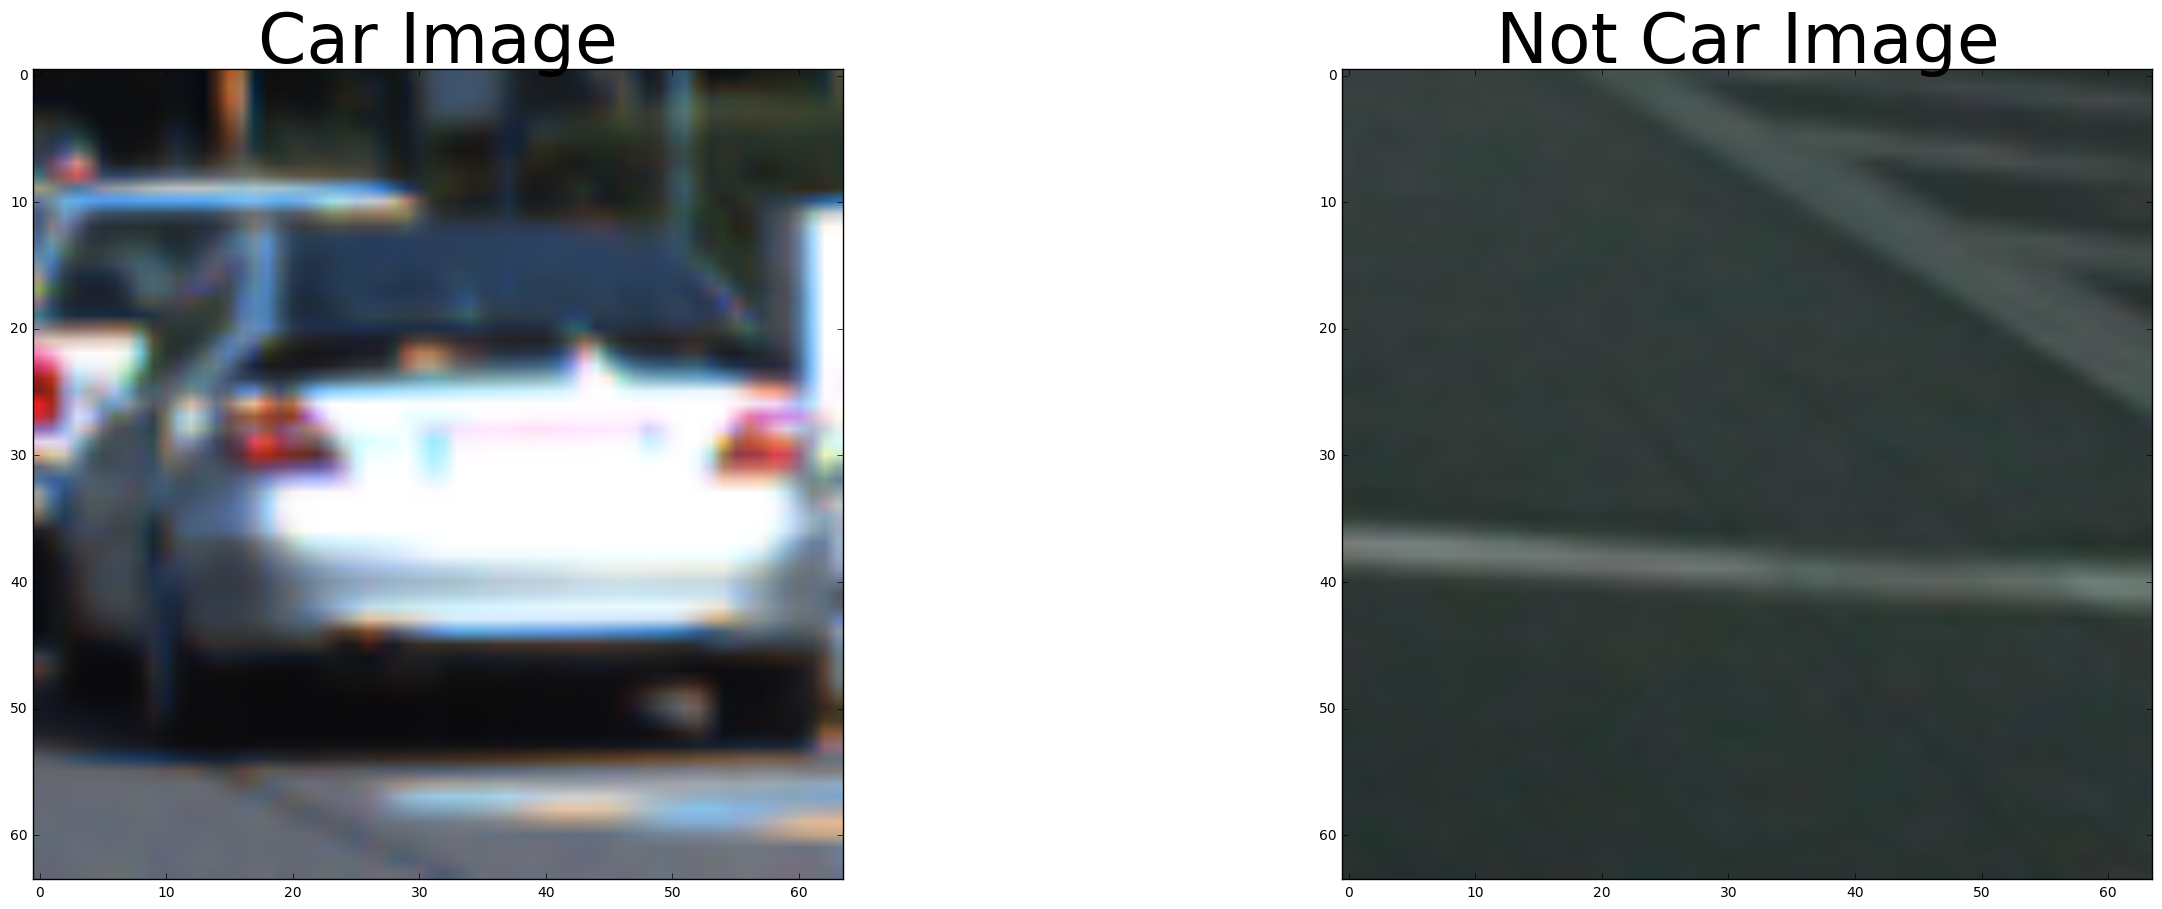

In [142]:
# No of training set
print("# Cars images: {}".format(len(cars)))
print("# Non-Car images: {}".format(len(notcars)))

#Display one car and one non car
carID=random.randint(0,len(cars))
notcarID=random.randint(0,len(notcars))

carImage=plt.imread(cars[carID])
notcarImage=plt.imread(notcars[notcarID])


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(carImage)
ax1.set_title("Car Image", fontsize=50)
ax2.imshow(notcarImage)
ax2.set_title("Not Car Image", fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()


In [150]:
car_features = extract_features(cars, cspace=cspace, orient=orient,
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                        hog_channel=hog_channel,nbins=histogram_bins)

notcar_features = extract_features(notcars, cspace=cspace, orient=orient,
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                        hog_channel=hog_channel,nbins=histogram_bins)



### Display HOG image

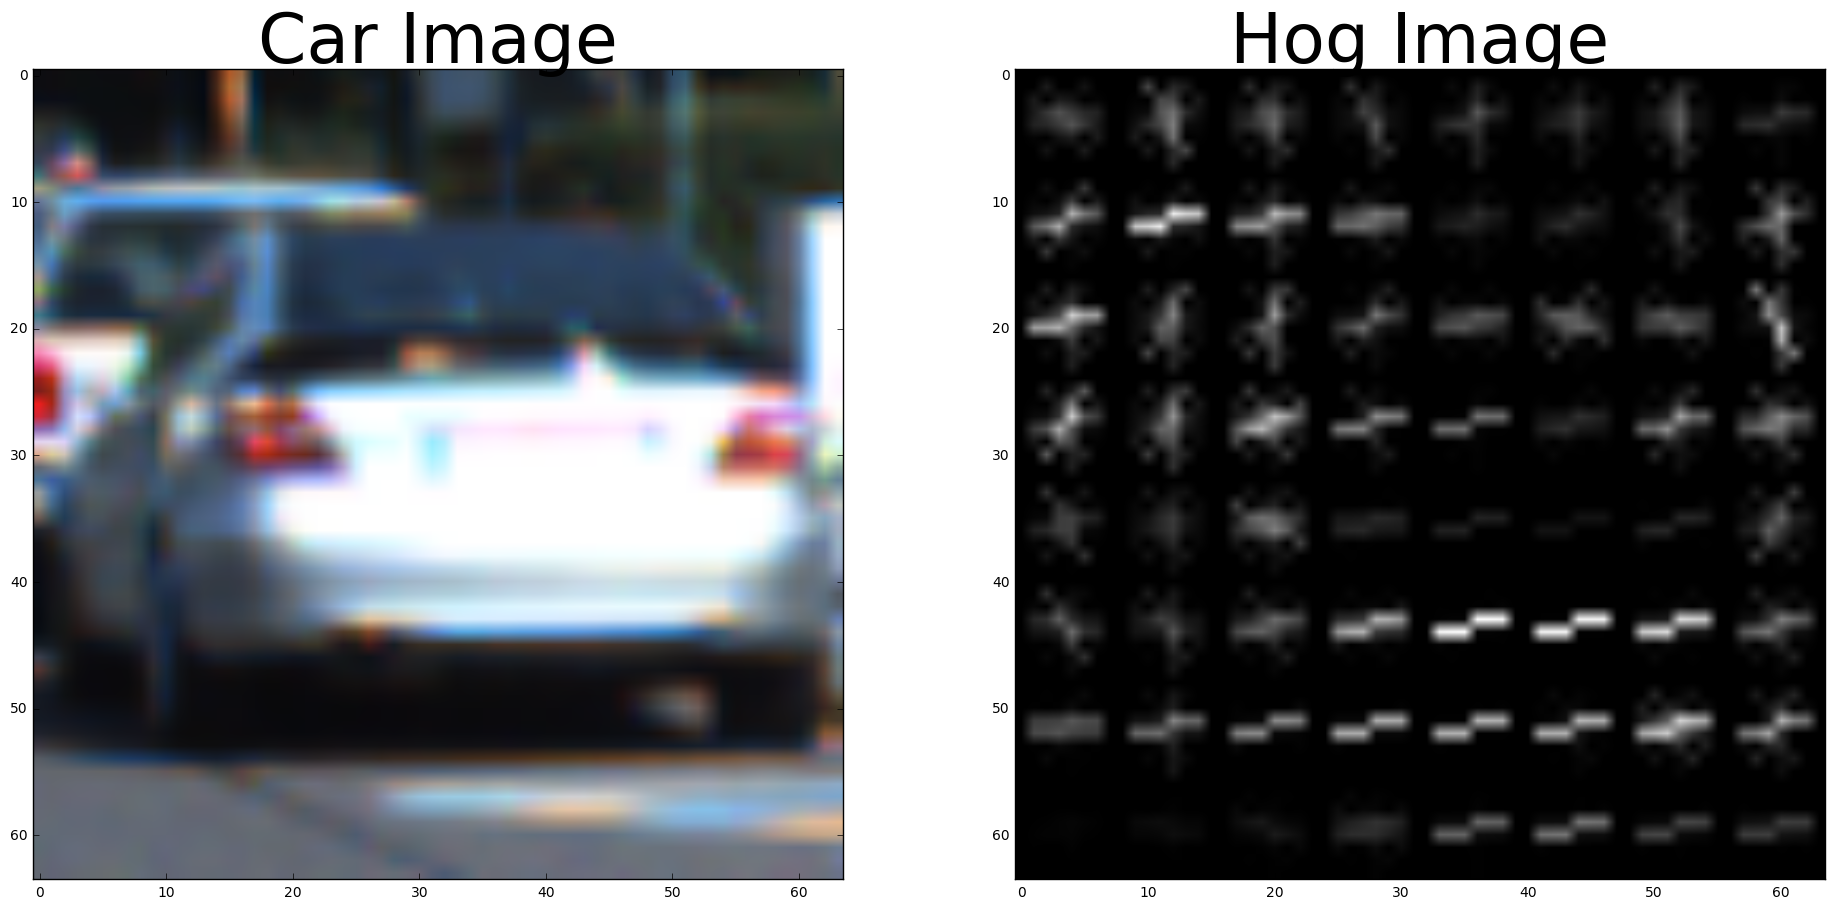

In [151]:
img=cv2.cvtColor(carImage,cv2.COLOR_RGB2GRAY)

feature,hog_image=get_hog_features(img, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                        vis=True, feature_vec=True)
    
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))
ax1.imshow(carImage)
ax1.set_title("Car Image", fontsize=50)
ax2.imshow(hog_image,cmap='gray')
ax2.set_title("Hog Image", fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()


### Train the classifier

In [152]:
# Get Training and test features
X_train,X_test,y_train,y_test,X_scaler=get_train_test(car_features, notcar_features)

# Train and test using SVC classifier
svc = LinearSVC()
# Check the training time for the SVC
svc.fit(X_train, y_train)
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample




Test Accuracy of SVC =  0.9716


In [153]:
# check predicton on above images
prediction=predict(carImage,svc,X_scaler,cspace=cspace, orient=orient,
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,nbins=histogram_bins)
print("prediction {}, Correct value : Car".format(prediction))

prediction=predict(notcarImage,svc,X_scaler,cspace=cspace, orient=orient,
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,nbins=histogram_bins)

print("prediction {}, Correct value : Not Car".format(prediction))


prediction Car, Correct value : Car
prediction No car, Correct value : Not Car


### Create functions

In [244]:
import cv2
from skimage.feature import hog

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None],
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5),mask_window=None):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step)
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step)
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            if mask_window is not None:
                if mask_window[int(starty)][int(startx)] > 0:
                    # Append window position to list
                    window_list.append(((startx, starty), (endx, endy)))
            else:
                window_list.append(((startx, starty), (endx, endy)))
                
            # Append window position to list
            #window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def search_windows(img, windows,clf,scaler, cspace=cspace, orient=orient,
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                        hog_channel=hog_channel,nbins=histogram_bins):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #print(windows)
    #2) Iterate over all windows in the list
    for window in windows:
        #print("window",window)
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        #4) Extract features for that window using single_img_features()
        features = extract_single_feature(test_img, cspace=cspace, orient=orient,
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                        hog_channel=hog_channel,nbins=histogram_bins)
        #print("features",features)
        
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #test_features= normalize_feature(features)
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #print("prediction",prediction)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows



    
def get_sliding_windows(image):
    y_start_stop = [400,720]
    x_start_stop= [600,1280]
    
    #mask = np.zeros_like(mpimg.imread('test_images/test1.jpg')[:,:,0])
    
    mask = np.zeros_like(image[:,:,0])   
    points = np.array([[(700,400),(1000,720),(1280,720),(1280,400)]])
    mask = cv2.fillPoly(mask, points, 1)
    
       
    windows1 = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop,
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5),mask_window=mask)
    #550
    
    y_start_stop = [400,720]
    x_start_stop= [600,1280]
   
    windows2 = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop,
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5),mask_window=mask)
    
    y_start_stop = [400,720]
    x_start_stop= [600,1280]
   
    windows3 = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop,
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5),mask_window=mask)
    
    y_start_stop = [400,500]
    x_start_stop= [600,1280]
   
    windows4 = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop,
                    xy_window=(100, 100), xy_overlap=(0.7, 0.7),mask_window=mask)
    
    
    #return windows1+windows2+windows3+windows4
    return windows1+windows2+windows4
    

def drawBox(image,svc=svc,X_scaler=X_scaler,cspace=cspace, orient=orient,
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,hog_channel=hog_channel,nbins=histogram_bins):
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    drawImage=np.copy(image)
    
    image = image.astype(np.float32)/255
    windows=get_sliding_windows(image)
    
    hot_windows = search_windows(image, windows,svc,X_scaler,cspace=cspace, orient=orient,
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,hog_channel=hog_channel,nbins=histogram_bins)
    
    
    #window_img = draw_boxes(drawImage, hot_windows, color=(0, 0, 255), thick=6)
    
    heat = add_heat(heat,hot_windows)
    
    heat = apply_threshold(heat,2)

    # Visualize the heatmap when displaying
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(drawImage), labels) 
    return draw_img

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def test_Box_On_Image(image_number):
    # Read in image

    testImage = mpimg.imread('test_images/test' + str(image_number) + '.jpg')
    draw_image = np.copy(testImage)

    testImage = testImage.astype(np.float32)/255
    windows=get_sliding_windows(testImage)

    hot_windows = search_windows(testImage, windows,svc,X_scaler,cspace=cspace, orient=orient,
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,hog_channel=hog_channel)
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
 
    # Plot image with bounding boxes drawn.
    heat = np.zeros_like(draw_image[:,:,0]).astype(np.float)
    heat = add_heat(heat,hot_windows)
    #print(hot_windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,2)

    # Visualize the heatmap when displaying
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(draw_image), labels)

    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))

    ax1.imshow(window_img)
    ax1.set_title("Original with box")

    ax2.imshow(heatmap,cmap='hot')    
    ax2.set_title("Heat Map")

    ax3.imshow(draw_img)    
    ax3.set_title("After heatmap Boxes")
    plt.show()
    



### Test pipeline using  a test images

file:test1.jpg


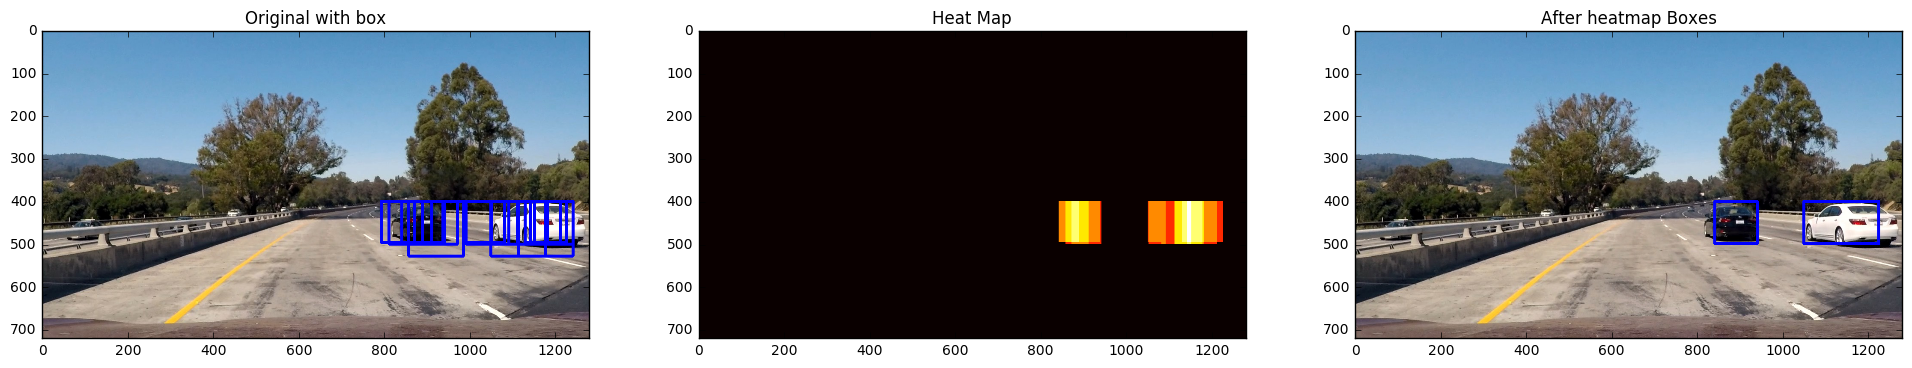

file:test2.jpg


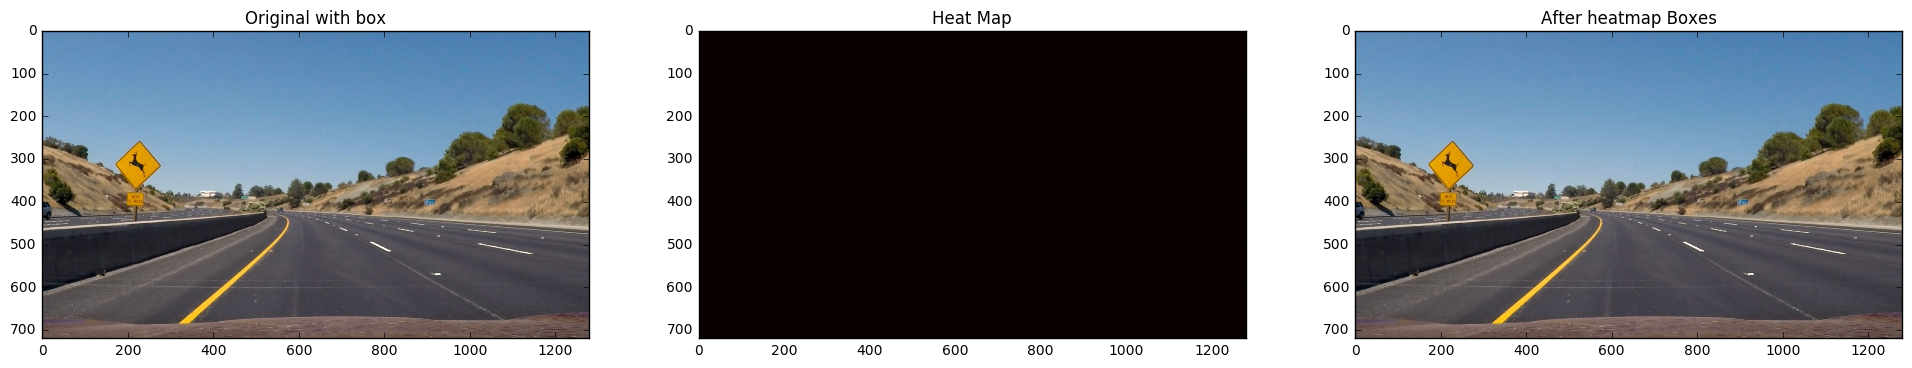

file:test3.jpg


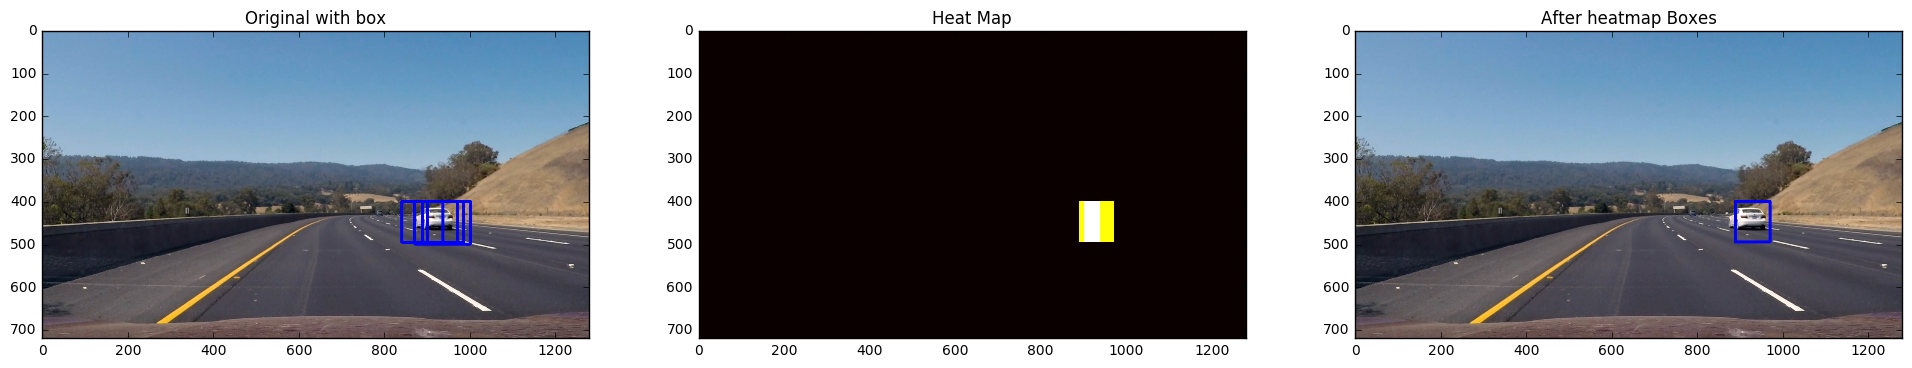

file:test4.jpg


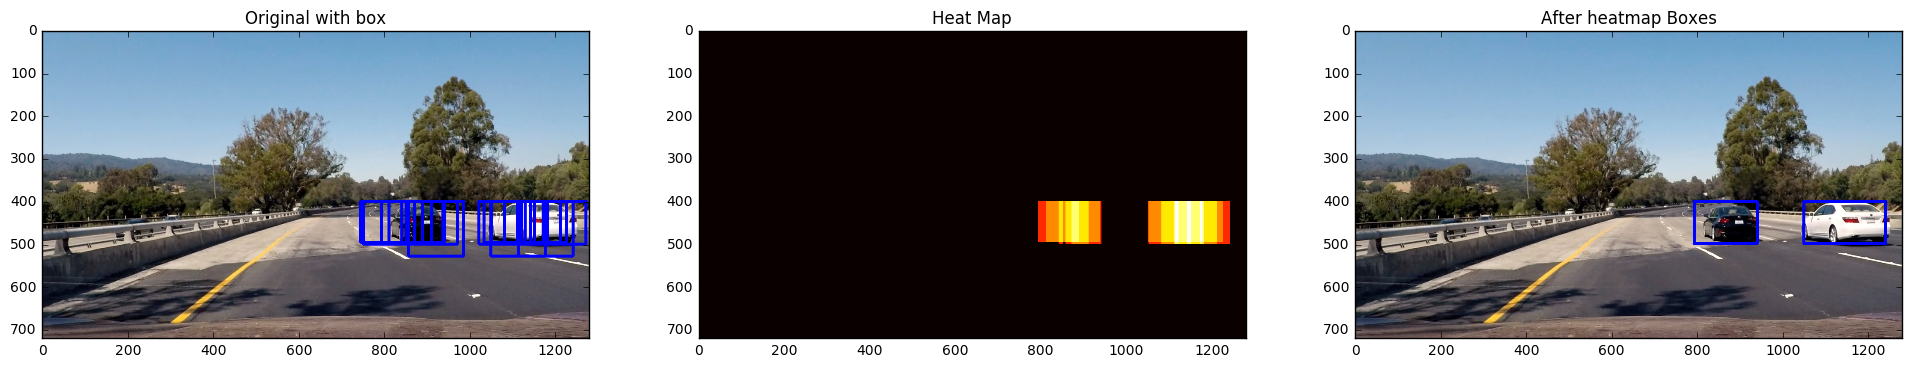

file:test5.jpg


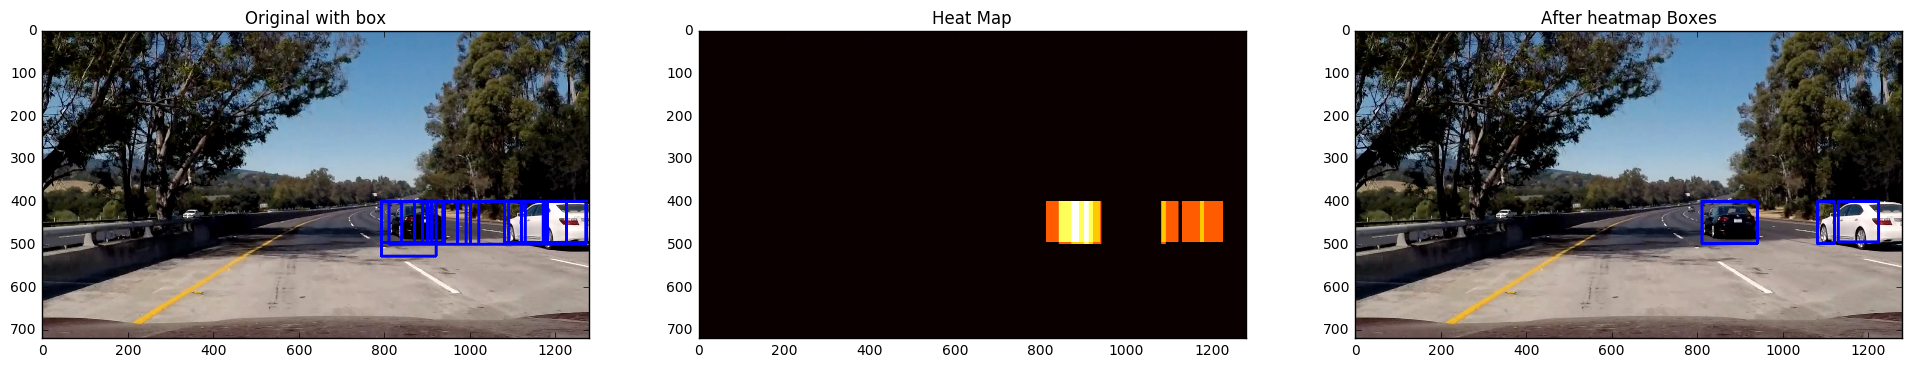

file:test6.jpg


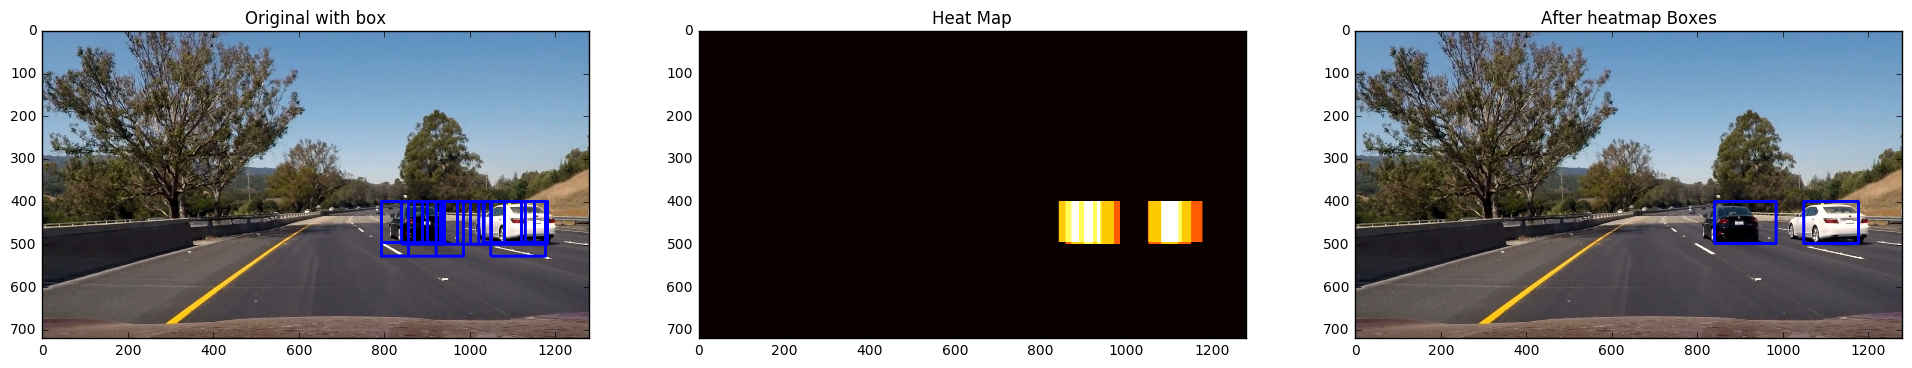

In [245]:
for i in range(1,7):
    print("file:test{}.jpg".format(i))
    test_Box_On_Image(i)

### Pipeline with Video

In [246]:
# Run data pipeline with Project Video file

project_output = 'project_video_output.mp4'
clip = VideoFileClip("project_video.mp4");
white_clip = clip.fl_image(drawBox)
white_clip.write_videofile(project_output, audio=False);



[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [06:38<00:00,  3.24it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

